<a href="https://colab.research.google.com/github/mohituoh/DeepLearning/blob/master/pretrained_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

In [ ]:
transform_train=transforms.Compose( [transforms.RandomResizedCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)), 
])

transform_test=transforms.Compose( [transforms.RandomResizedCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),   
])

In [ ]:
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [ ]:
vgg=models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
for param in vgg.parameters():
  param.requires_grad=False

In [ ]:
fianl_in_feature=vgg.classifier[6].in_features

In [ ]:
mod_classifier=list(vgg.classifier[:-1])
mod_classifier.extend([nn.Linear(in_features=4096,out_features=10,bias=True)])

In [ ]:
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [ ]:
vgg.classifier=nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
for param in vgg.parameters():

  if param.requires_grad:
    print(param.shape)



torch.Size([10, 4096])
torch.Size([10])


In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
import torch.optim as optim

In [ ]:
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.5)

In [ ]:
def evaluation(dataloader,model):
  total,correct=0,0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    outputs=model(inputs)
    _,pred=torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
    return 100*correct/total

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
loss_epoch_arr=[]
max_epoch=1
n_iters=np.ceil(50000/batch_size)
for epoch in range(max_epoch):
  for i , data in enumerate(trainloader,0):
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    opt.zero_grad()
    outputs=vgg(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()
    del inputs,labels,outputs
    torch.cuda.empty_cache()

    if i%100==0:
      print("iteration %d %d  loss : %2f"%(i,n_iters,loss.item()))
  loss_epoch_arr.append(loss.item())
  print("epoch: %d %d,Test_acc: %0.2f ,Train_acc: %0.2f" %(epoch,max_epoch,evaluation(testloader,vgg),evaluation(trainloader,vgg)))
plt.plot(loss_epoch_arr)
plt.show()


iteration 0 3125  loss : 2.339645
iteration 100 3125  loss : 16.792267
iteration 200 3125  loss : 10.673313
iteration 300 3125  loss : 9.590130
iteration 400 3125  loss : 30.527283
iteration 500 3125  loss : 18.876890
iteration 600 3125  loss : 25.137667
iteration 700 3125  loss : 20.089781
iteration 800 3125  loss : 14.633277
iteration 900 3125  loss : 13.536448
iteration 1000 3125  loss : 19.760080
iteration 1100 3125  loss : 17.484837
iteration 1200 3125  loss : 12.344474


KeyboardInterrupt: ignored

#with model *copies*

In [ ]:
import copy

Min loss :- 20.88
iteration 0 3125  loss : 20.884094
Min loss :- 18.46
Min loss :- 12.17
Min loss :- 8.88
Min loss :- 4.39
iteration 100 3125  loss : 20.701723
iteration 200 3125  loss : 21.674971
iteration 300 3125  loss : 34.192833
Min loss :- 3.73
iteration 400 3125  loss : 30.927013
iteration 500 3125  loss : 31.268108
iteration 600 3125  loss : 20.107315
iteration 700 3125  loss : 17.207731
iteration 800 3125  loss : 7.136998
iteration 900 3125  loss : 18.395866
iteration 1000 3125  loss : 15.521329
iteration 1100 3125  loss : 23.635008
iteration 1200 3125  loss : 31.243719
iteration 1300 3125  loss : 32.038406
iteration 1400 3125  loss : 28.578671
iteration 1500 3125  loss : 17.831371
iteration 1600 3125  loss : 25.293209
iteration 1700 3125  loss : 24.711618
iteration 1800 3125  loss : 29.233196
iteration 1900 3125  loss : 27.377550
iteration 2000 3125  loss : 25.874582
iteration 2100 3125  loss : 38.459560
iteration 2200 3125  loss : 25.667604
iteration 2300 3125  loss : 31.426

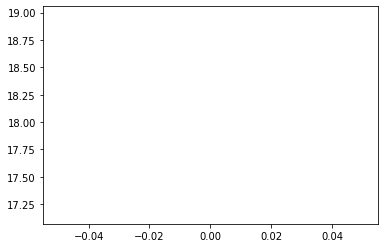

In [ ]:
loss_epoch_arr=[]
max_epoch=1
min_loss=1000
n_iters=np.ceil(50000/batch_size)
for epoch in range(max_epoch):
  for i , data in enumerate(trainloader,0):
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    opt.zero_grad()
    outputs=vgg(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()
    if min_loss>loss.item():
      min_loss=loss.item()
      best_model= copy.deepcopy(vgg.state_dict())
      print("Min loss :- %0.2f" % min_loss)


    del inputs,labels,outputs
    torch.cuda.empty_cache()

    if i%100==0:
      print("iteration %d %d  loss : %2f"%(i,n_iters,loss.item()))
  loss_epoch_arr.append(loss.item())
  print("epoch: %d %d,Test_acc: %0.2f ,Train_acc: %0.2f" %(epoch,max_epoch,evaluation(testloader,vgg),evaluation(trainloader,vgg)))
plt.plot(loss_epoch_arr)
plt.show()


In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(testloader,vgg),evaluation(trainloader,vgg))

50.0 37.5
